# Frozen Smoke

**Purpose:** Visualize the internal structure of the three main connected components
in the spongecrystal neighborhood.

**Prerequisite:** Run `spongecrystal_survey.ipynb` first.

---

## What We Know

The "spongecrystal" isn't a crystal at all. It's **frozen smoke**:
- 3 main connected components (15, 8, and 7 vectors)
- Density ~60% within each component (not cliques, not trees—webby)
- Components separated by L∞=2 to L∞=8 (Mormons dancing)
- 91 isolated singletons floating in the void

All adjacent pairs (L∞=1) share identical exponents in all 2560 dimensions,
so our topology is valid even though absolute positioning is tricky.

## Visualizations

1. **Component graphs** — topology of each cluster
2. **Adjacency heatmaps** — who's connected to whom
3. **Degree distribution** — hub vs leaf structure
4. **Near-miss analysis** — the L∞=2 bridges that almost connect components
5. **Black hole geography** — where do the big attractors sit?

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from safetensors.torch import load_file
from pathlib import Path

# Load saved data
DATA_DIR = Path("../../tensors/Qwen3-4B-Instruct-2507")

W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
masks = load_file(DATA_DIR / "masks.safetensors")
neighborhood_mask = masks['neighborhood_mask']

print(f"Loaded W: {W.shape}")
print(f"Neighborhood tokens: {neighborhood_mask.sum().item():,}")

Loaded W: torch.Size([151936, 2560])
Neighborhood tokens: 2,212


In [44]:
# Build unique vectors and graph (same as topology notebook)
neighborhood_indices = torch.where(neighborhood_mask)[0]
W_neighborhood = W[neighborhood_indices]

unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)
n_unique = len(unique_bits)
unique_bf16 = unique_bits.to(torch.uint16).view(torch.bfloat16)

# Lattice coordinates (valid for same-exponent comparisons)
def compute_lattice_coords(W_bf16):
    bits = W_bf16.view(torch.uint16).to(torch.int32)
    exponent = (bits >> 7) & 0xFF
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return W_bf16.float() / ulp

lattice_coords = compute_lattice_coords(unique_bf16)

# L∞ distance matrix
def compute_linf(a, b):
    diff = torch.abs(a.unsqueeze(1) - b.unsqueeze(0))
    return diff.max(dim=2).values

linf_matrix = compute_linf(lattice_coords, lattice_coords)

print(f"Unique vectors: {n_unique}")
print(f"Distance matrix: {linf_matrix.shape}")

Unique vectors: 125
Distance matrix: torch.Size([125, 125])


In [45]:
# Build graph
G = nx.Graph()

token_counts = counts.numpy()
for i in range(n_unique):
    G.add_node(i, token_count=int(token_counts[i]),
               is_black_hole=(token_counts[i] > 1))

adj = (linf_matrix >= 0.5) & (linf_matrix <= 1.5) & ~torch.eye(n_unique, dtype=torch.bool)
edges = torch.where(adj)
for i, j in zip(edges[0].tolist(), edges[1].tolist()):
    if i < j:
        G.add_edge(i, j)

# Find components
components = sorted(nx.connected_components(G), key=len, reverse=True)
top3 = [list(c) for c in components[:3]]

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"\nTop 3 components:")
for i, comp in enumerate(top3):
    tokens = sum(G.nodes[n]['token_count'] for n in comp)
    bh = sum(1 for n in comp if G.nodes[n]['is_black_hole'])
    print(f"  C{i+1}: {len(comp)} vectors, {tokens:,} tokens, {bh} black holes")

Graph: 125 nodes, 100 edges

Top 3 components:
  C1: 15 vectors, 1,070 tokens, 5 black holes
  C2: 8 vectors, 712 tokens, 2 black holes
  C3: 7 vectors, 312 tokens, 1 black holes


/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_19321/1395281021.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


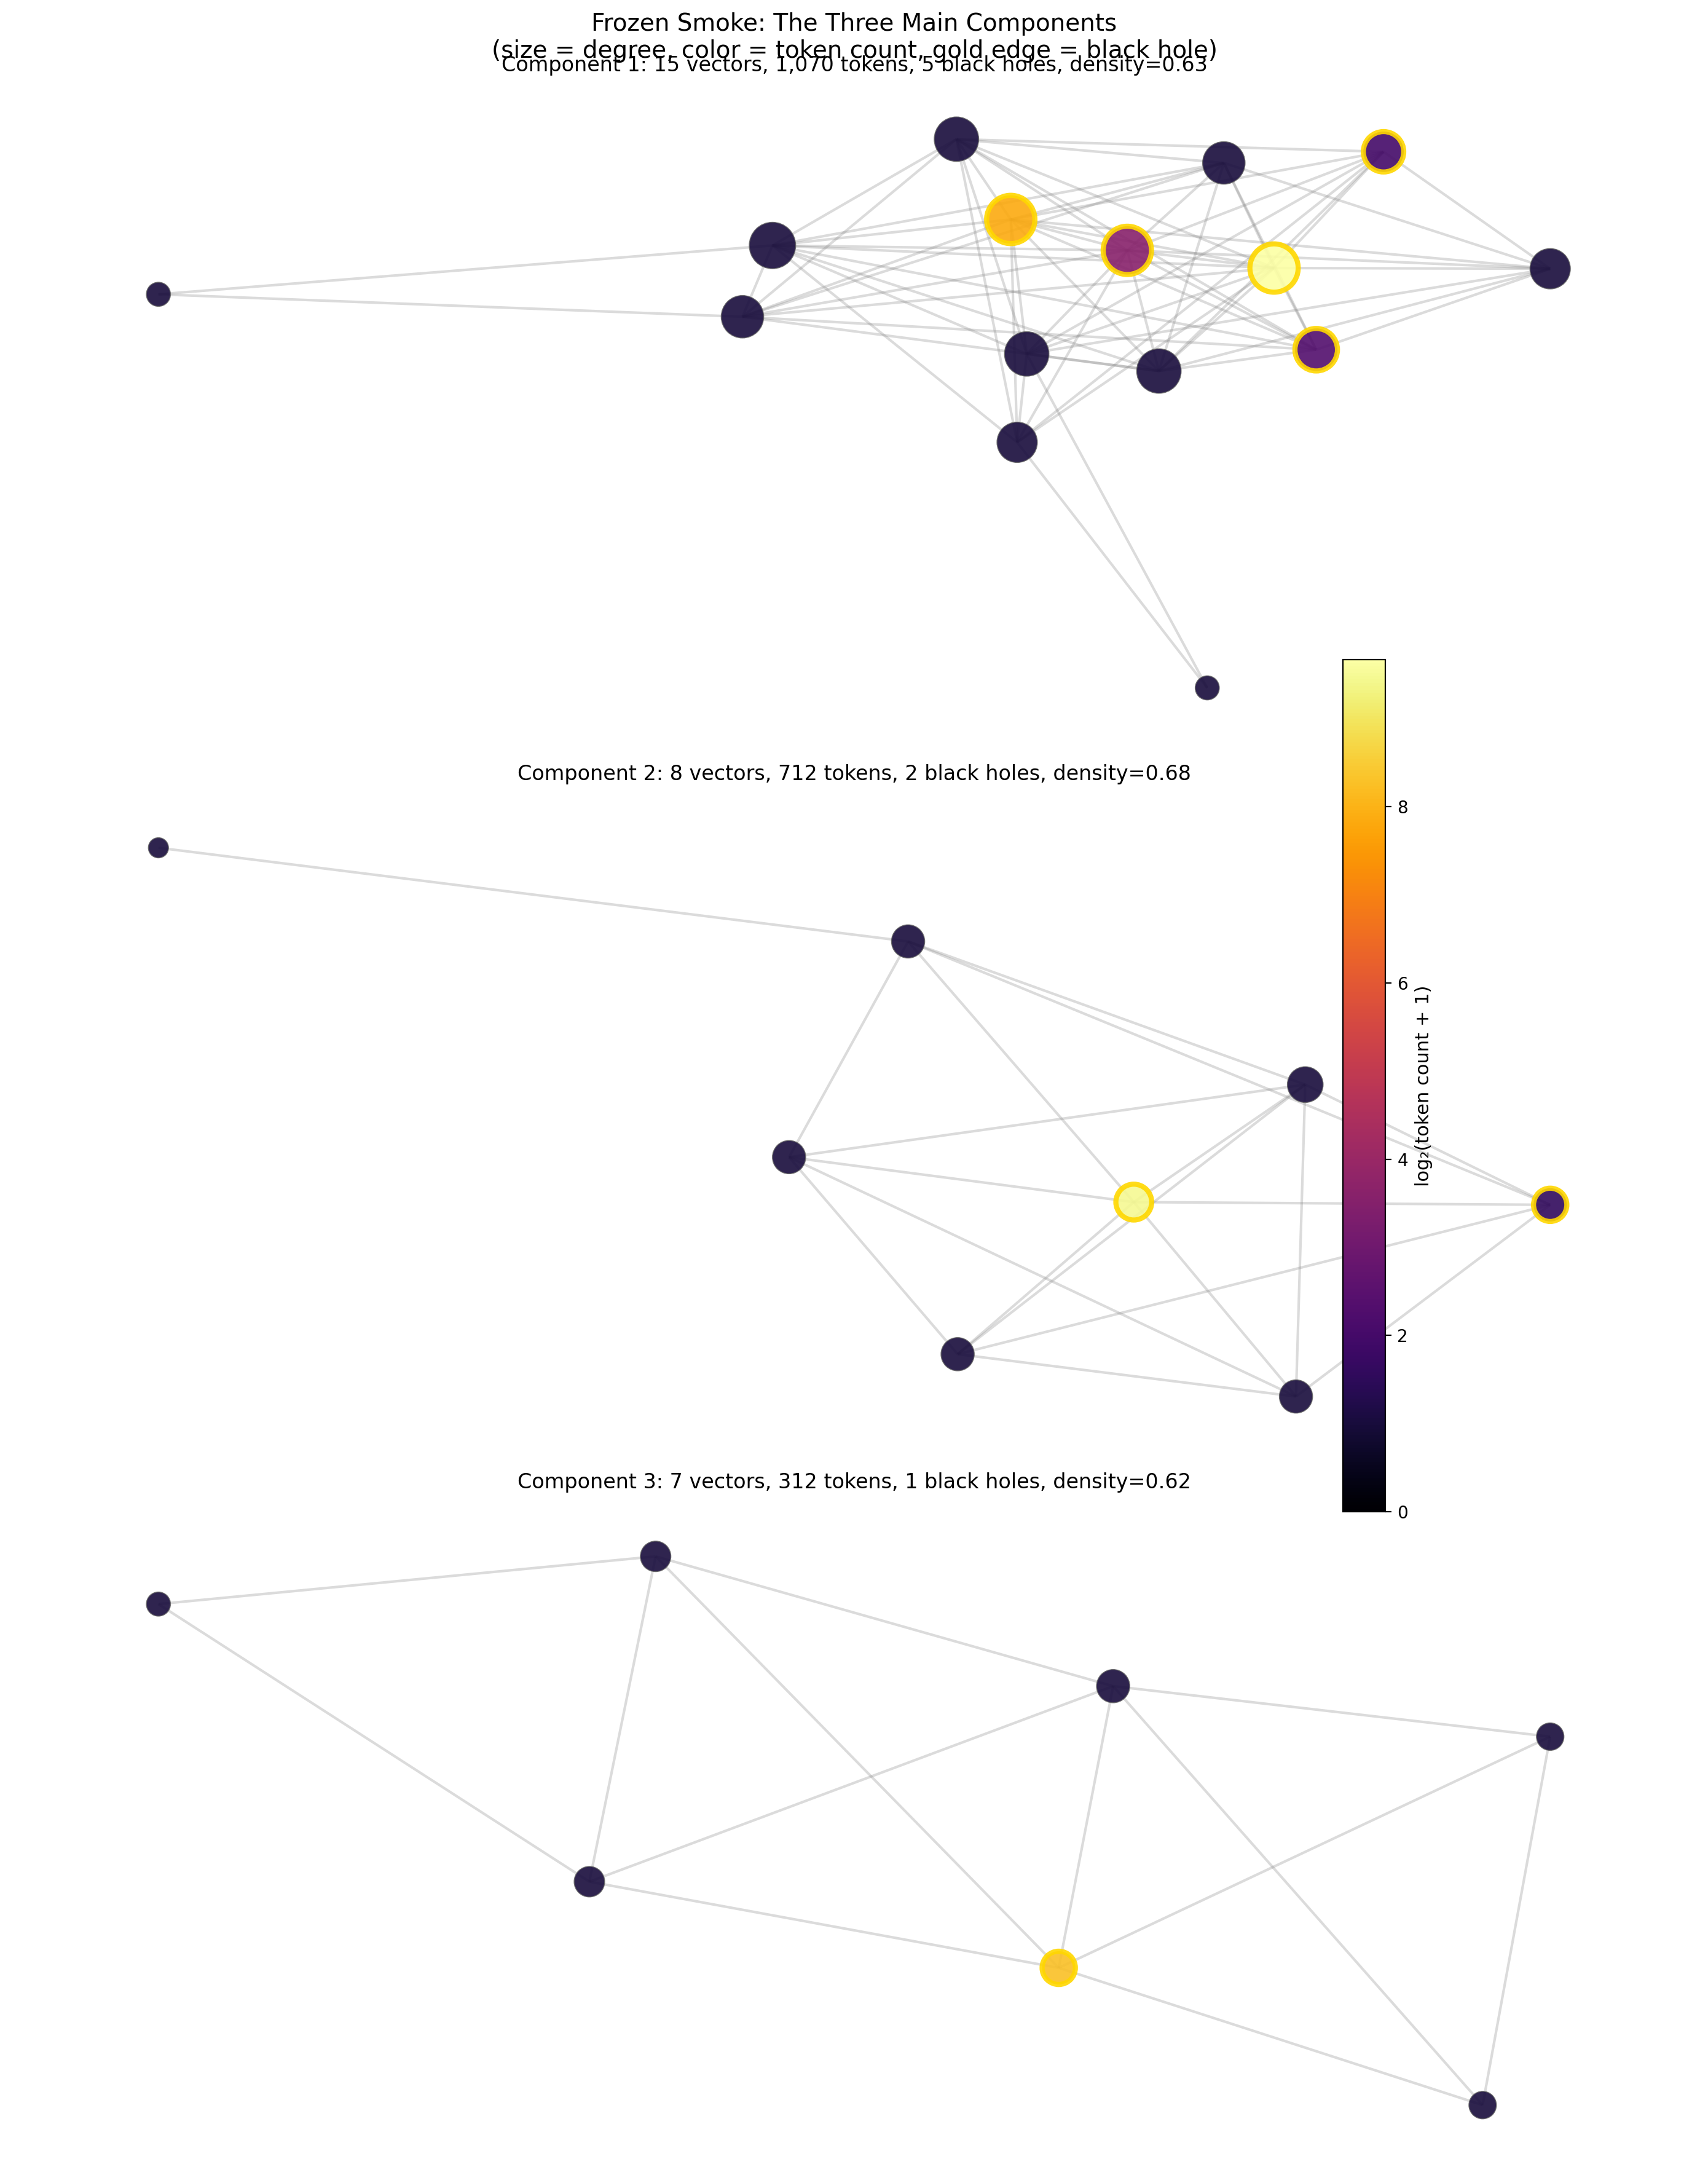

In [46]:
fig, axes = plt.subplots(3, 1, figsize=(14, 18), dpi=200)

for idx, (comp, ax) in enumerate(zip(top3, axes)):
    subgraph = G.subgraph(comp).copy()
    
    # Layout
    pos = nx.spring_layout(subgraph, seed=42, k=2, iterations=100)
    
    # Node properties
    nodes = list(subgraph.nodes())
    degrees = [subgraph.degree(n) for n in nodes]
    token_cts = [G.nodes[n]['token_count'] for n in nodes]
    is_bh = [G.nodes[n]['is_black_hole'] for n in nodes]
    
    # Size by degree (range 1-12ish, scale up for visibility)
    sizes = [80 + d * 60 for d in degrees]
    
    # Color by log token count
    colors = [np.log2(tc + 1) for tc in token_cts]
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.3, 
                           edge_color='#888888', width=1.5)
    
    # Draw nodes
    scatter = nx.draw_networkx_nodes(subgraph, pos, nodelist=nodes, ax=ax,
                                     node_size=sizes, node_color=colors,
                                     cmap='inferno', alpha=0.9,
                                     vmin=0, vmax=np.log2(815),
                                     edgecolors=['gold' if bh else '#666666' for bh in is_bh],
                                     linewidths=[3 if bh else 0.5 for bh in is_bh])
    
    # Stats
    total_tokens = sum(token_cts)
    n_bh = sum(is_bh)
    density = nx.density(subgraph)
    
    ax.set_title(f'Component {idx+1}: {len(comp)} vectors, {total_tokens:,} tokens, '
                 f'{n_bh} black holes, density={density:.2f}',
                 fontsize=12)
    ax.axis('off')

# Colorbar on the side
sm = plt.cm.ScalarMappable(cmap='inferno', 
                           norm=plt.Normalize(vmin=0, vmax=np.log2(815)))
cbar = fig.colorbar(sm, ax=axes, shrink=0.5, pad=0.02, location='right')
cbar.set_label('log₂(token count + 1)', fontsize=11)

plt.suptitle('Frozen Smoke: The Three Main Components\n'
             '(size = degree, color = token count, gold edge = black hole)',
             fontsize=14)
plt.tight_layout()
plt.savefig('../../notebooks/analysis/frozen_smoke_components.png', 
            dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_19321/2883983688.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


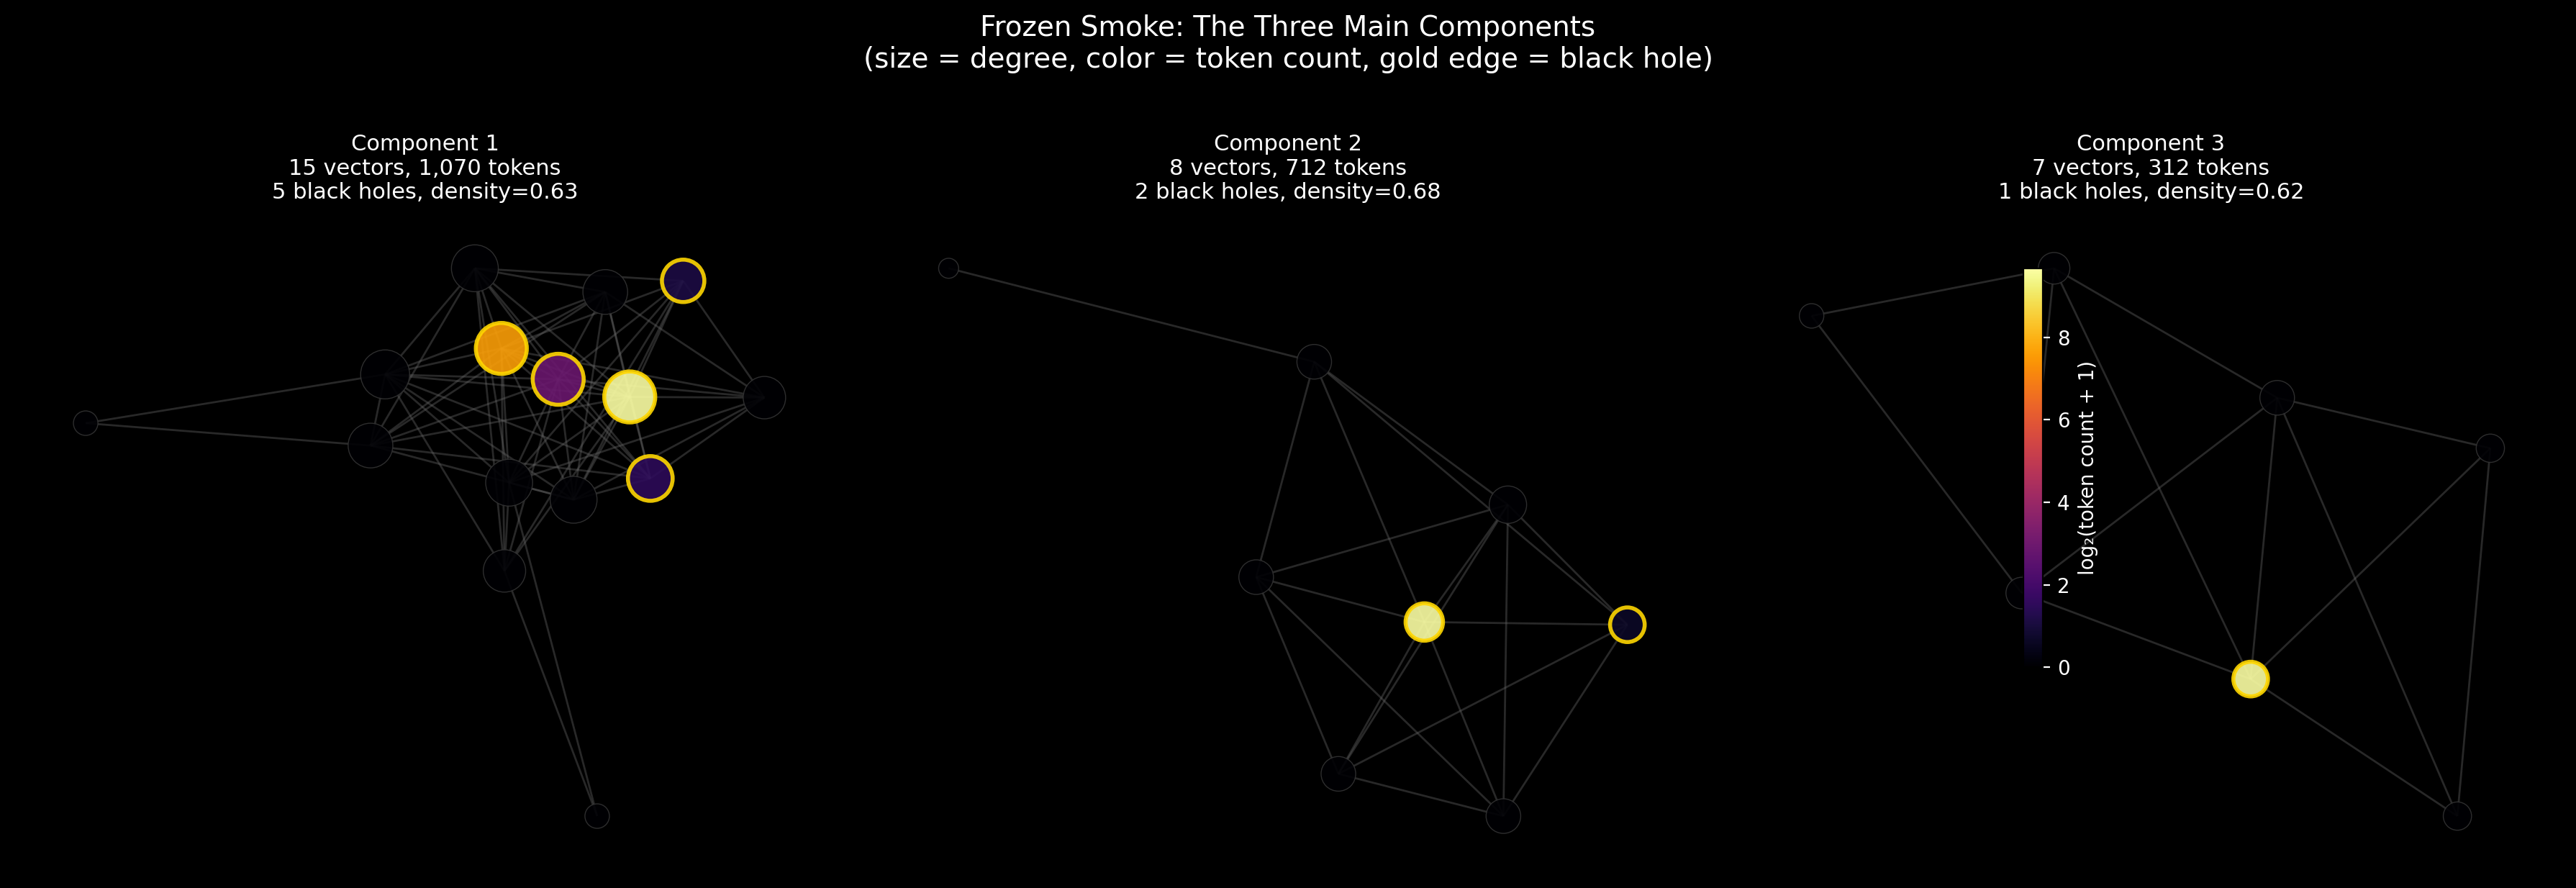

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)
fig.patch.set_facecolor('black')

for idx, (comp, ax) in enumerate(zip(top3, axes)):
    ax.set_facecolor('black')
    subgraph = G.subgraph(comp).copy()
    
    # Layout
    pos = nx.spring_layout(subgraph, seed=42, k=2, iterations=100)
    
    # Node properties
    nodes = list(subgraph.nodes())
    degrees = [subgraph.degree(n) for n in nodes]
    token_cts = [G.nodes[n]['token_count'] for n in nodes]
    is_bh = [G.nodes[n]['is_black_hole'] for n in nodes]
    
    # Size by degree (range 1-12ish, scale to 100-600)
    sizes = [50 + d * 50 for d in degrees]
    
    # Color by log token count
    colors = [np.log2(tc + 1) for tc in token_cts]
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.4, 
                           edge_color='#666666', width=1)
    
    # Draw nodes
    scatter = nx.draw_networkx_nodes(subgraph, pos, nodelist=nodes, ax=ax,
                                     node_size=sizes, node_color=colors,
                                     cmap='inferno', alpha=0.9,
                                     edgecolors=['gold' if bh else '#333333' for bh in is_bh],
                                     linewidths=[2 if bh else 0.5 for bh in is_bh])
    
    # Stats
    total_tokens = sum(token_cts)
    n_bh = sum(is_bh)
    density = nx.density(subgraph)
    
    ax.set_title(f'Component {idx+1}\n{len(comp)} vectors, {total_tokens:,} tokens\n'
                 f'{n_bh} black holes, density={density:.2f}',
                 fontsize=11, color='white')
    ax.axis('off')

# Colorbar
sm = plt.cm.ScalarMappable(cmap='inferno', 
                           norm=plt.Normalize(vmin=0, vmax=np.log2(815)))
cbar = fig.colorbar(sm, ax=axes, shrink=0.6, pad=0.02)
cbar.set_label('log₂(token count + 1)', color='white', fontsize=10)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.suptitle('Frozen Smoke: The Three Main Components\n'
             '(size = degree, color = token count, gold edge = black hole)',
             fontsize=14, color='white', y=1.02)
plt.tight_layout()
plt.savefig('../../notebooks/analysis/frozen_smoke_components.png', 
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## 2. Adjacency Heatmaps

For each component, show the pairwise L∞ distances. White = adjacent (L∞=1).

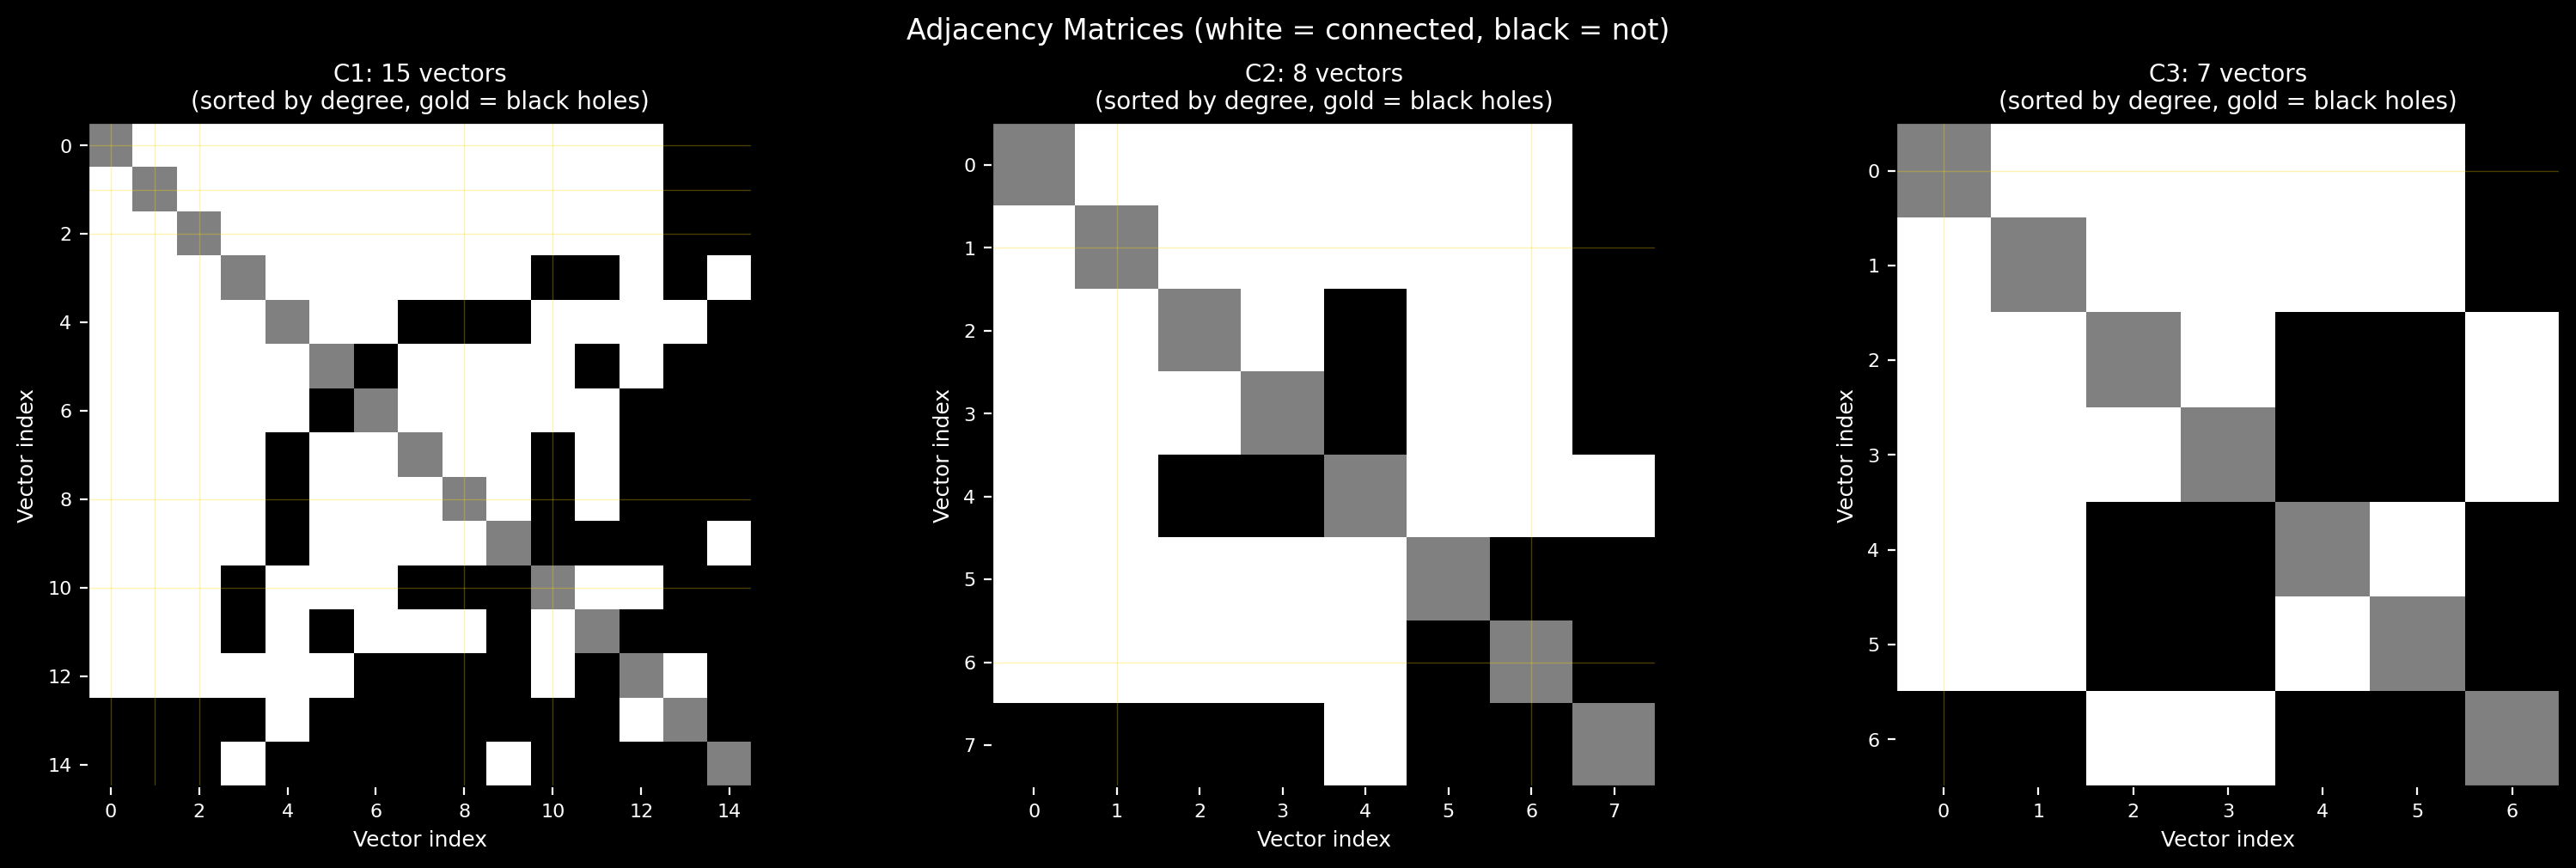

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=200)
fig.patch.set_facecolor('black')

for idx, (comp, ax) in enumerate(zip(top3, axes)):
    ax.set_facecolor('black')
    
    # Sort nodes by degree (high-degree nodes first)
    subgraph = G.subgraph(comp)
    sorted_nodes = sorted(comp, key=lambda n: subgraph.degree(n), reverse=True)
    
    # Extract submatrix
    sub_linf = linf_matrix[sorted_nodes][:, sorted_nodes].numpy()
    
    # Binary adjacency (1 if L∞ <= 1.5, else 0)
    adj_binary = (sub_linf <= 1.5).astype(float)
    np.fill_diagonal(adj_binary, 0.5)  # Self = gray
    
    im = ax.imshow(adj_binary, cmap='gray', vmin=0, vmax=1, aspect='equal')
    
    # Mark black holes on axes
    bh_positions = [i for i, n in enumerate(sorted_nodes) if G.nodes[n]['is_black_hole']]
    for pos in bh_positions:
        ax.axhline(y=pos, color='gold', alpha=0.3, linewidth=0.5)
        ax.axvline(x=pos, color='gold', alpha=0.3, linewidth=0.5)
    
    ax.set_title(f'C{idx+1}: {len(comp)} vectors\n(sorted by degree, gold = black holes)',
                 fontsize=10, color='white')
    ax.set_xlabel('Vector index', fontsize=9, color='white')
    ax.set_ylabel('Vector index', fontsize=9, color='white')
    ax.tick_params(colors='white', labelsize=8)

plt.suptitle('Adjacency Matrices (white = connected, black = not)',
             fontsize=12, color='white')
plt.tight_layout()
plt.savefig('../../notebooks/analysis/frozen_smoke_adjacency.png',
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## 3. Degree Distribution

How connected is each node? Are black holes hubs or leaves?

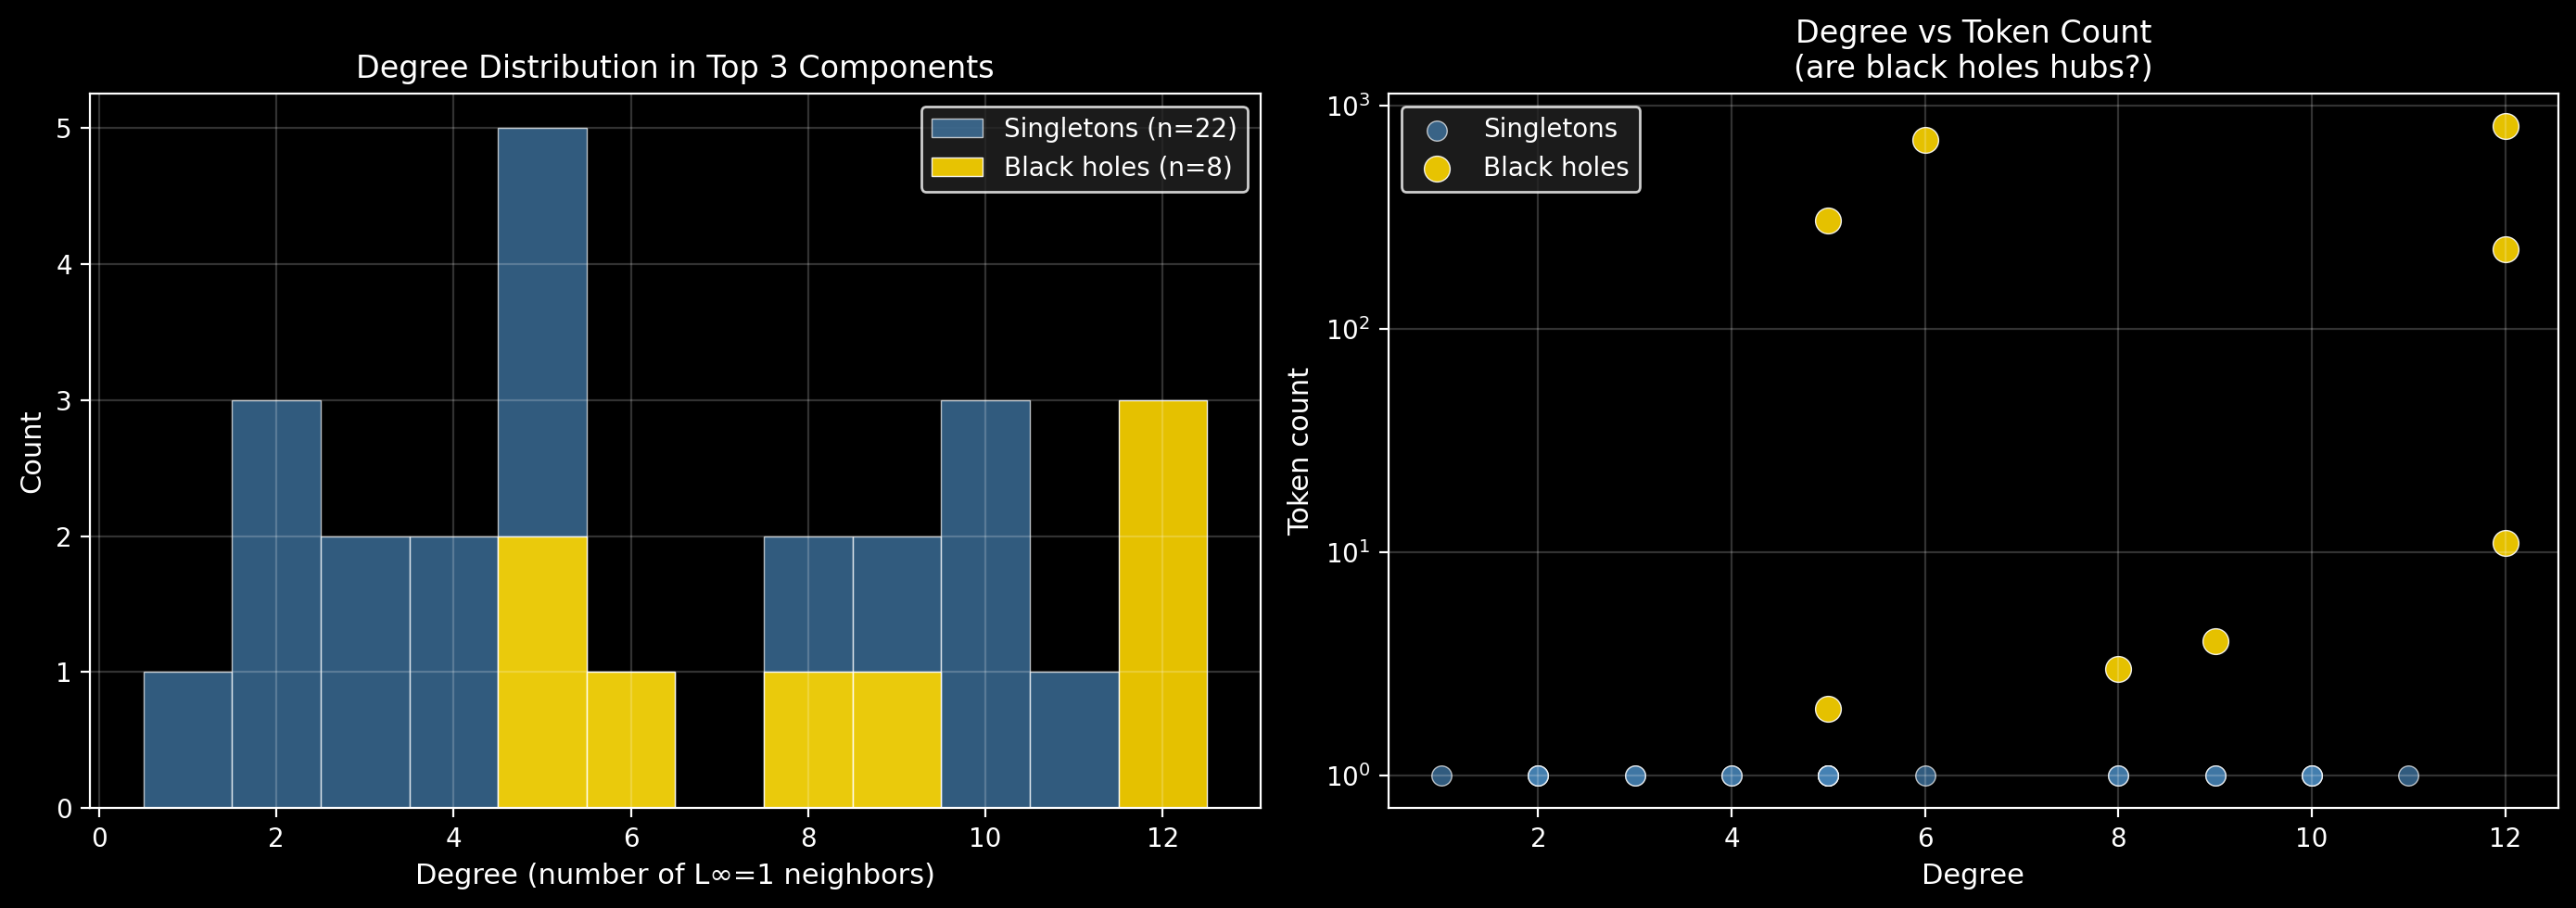

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)
fig.patch.set_facecolor('black')

# Left: histogram of degrees for all 3 components combined
ax = axes[0]
ax.set_facecolor('black')

all_nodes = top3[0] + top3[1] + top3[2]
degrees_all = [G.degree(n) for n in all_nodes]
degrees_bh = [G.degree(n) for n in all_nodes if G.nodes[n]['is_black_hole']]
degrees_singleton = [G.degree(n) for n in all_nodes if not G.nodes[n]['is_black_hole']]

bins = np.arange(0.5, max(degrees_all) + 1.5, 1)
ax.hist(degrees_singleton, bins=bins, alpha=0.7, color='steelblue', 
        label=f'Singletons (n={len(degrees_singleton)})', edgecolor='white', linewidth=0.5)
ax.hist(degrees_bh, bins=bins, alpha=0.9, color='gold',
        label=f'Black holes (n={len(degrees_bh)})', edgecolor='white', linewidth=0.5)

ax.set_xlabel('Degree (number of L∞=1 neighbors)', fontsize=11, color='white')
ax.set_ylabel('Count', fontsize=11, color='white')
ax.set_title('Degree Distribution in Top 3 Components', fontsize=12, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('white')
ax.grid(True, alpha=0.2, color='white')

# Right: degree vs token count scatter
ax = axes[1]
ax.set_facecolor('black')

degrees = [G.degree(n) for n in all_nodes]
token_cts = [G.nodes[n]['token_count'] for n in all_nodes]
is_bh = [G.nodes[n]['is_black_hole'] for n in all_nodes]

# Singletons
d_s = [d for d, bh in zip(degrees, is_bh) if not bh]
t_s = [t for t, bh in zip(token_cts, is_bh) if not bh]
ax.scatter(d_s, t_s, c='steelblue', s=60, alpha=0.7, label='Singletons', edgecolors='white', linewidths=0.5)

# Black holes
d_bh = [d for d, bh in zip(degrees, is_bh) if bh]
t_bh = [t for t, bh in zip(token_cts, is_bh) if bh]
ax.scatter(d_bh, t_bh, c='gold', s=100, alpha=0.9, label='Black holes', edgecolors='white', linewidths=0.5)

ax.set_xlabel('Degree', fontsize=11, color='white')
ax.set_ylabel('Token count', fontsize=11, color='white')
ax.set_yscale('log')
ax.set_title('Degree vs Token Count\n(are black holes hubs?)', fontsize=12, color='white')
ax.legend(facecolor='#222222', edgecolor='white', labelcolor='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('white')
ax.grid(True, alpha=0.2, color='white')

plt.tight_layout()
plt.savefig('../../notebooks/analysis/frozen_smoke_degrees.png',
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## 4. Near-Miss Analysis

Which nodes are L∞=2 apart between components? These are the "almost bridges."

In [50]:
# Find all inter-component near-misses (L∞ = 2)
print("Near-misses between components (L∞ = 2):")
print("="*60)

near_misses = []
for i in range(3):
    for j in range(i+1, 3):
        comp_i = top3[i]
        comp_j = top3[j]
        
        for ni in comp_i:
            for nj in comp_j:
                d = linf_matrix[ni, nj].item()
                if d <= 2.5:  # L∞ = 2
                    near_misses.append({
                        'comp_i': i+1, 'comp_j': j+1,
                        'node_i': ni, 'node_j': nj,
                        'dist': d,
                        'tokens_i': G.nodes[ni]['token_count'],
                        'tokens_j': G.nodes[nj]['token_count'],
                        'bh_i': G.nodes[ni]['is_black_hole'],
                        'bh_j': G.nodes[nj]['is_black_hole']
                    })

print(f"Found {len(near_misses)} near-miss pairs\n")

for nm in sorted(near_misses, key=lambda x: (x['comp_i'], x['comp_j'], x['dist'])):
    bh_i = "BH" if nm['bh_i'] else "  "
    bh_j = "BH" if nm['bh_j'] else "  "
    print(f"C{nm['comp_i']}→C{nm['comp_j']}: "
          f"node {nm['node_i']:3d} ({nm['tokens_i']:4d} tok {bh_i}) ↔ "
          f"node {nm['node_j']:3d} ({nm['tokens_j']:4d} tok {bh_j})  "
          f"L∞={nm['dist']:.0f}")

Near-misses between components (L∞ = 2):
Found 79 near-miss pairs

C1→C2: node  34 (   3 tok BH) ↔ node  58 (   1 tok   )  L∞=2
C1→C2: node  34 (   3 tok BH) ↔ node  59 (   1 tok   )  L∞=2
C1→C2: node  35 (   1 tok   ) ↔ node  56 (   1 tok   )  L∞=2
C1→C2: node  35 (   1 tok   ) ↔ node  58 (   1 tok   )  L∞=2
C1→C2: node  35 (   1 tok   ) ↔ node  59 (   1 tok   )  L∞=2
C1→C2: node  35 (   1 tok   ) ↔ node  60 (   1 tok   )  L∞=2
C1→C2: node  35 (   1 tok   ) ↔ node  61 ( 704 tok BH)  L∞=2
C1→C2: node  35 (   1 tok   ) ↔ node  62 (   2 tok BH)  L∞=2
C1→C2: node  36 (   1 tok   ) ↔ node  58 (   1 tok   )  L∞=2
C1→C2: node  36 (   1 tok   ) ↔ node  59 (   1 tok   )  L∞=2
C1→C2: node  37 (   1 tok   ) ↔ node  58 (   1 tok   )  L∞=2
C1→C2: node  37 (   1 tok   ) ↔ node  59 (   1 tok   )  L∞=2
C1→C2: node  38 (   1 tok   ) ↔ node  56 (   1 tok   )  L∞=2
C1→C2: node  38 (   1 tok   ) ↔ node  58 (   1 tok   )  L∞=2
C1→C2: node  38 (   1 tok   ) ↔ node  59 (   1 tok   )  L∞=2
C1→C2: node  38 ( 

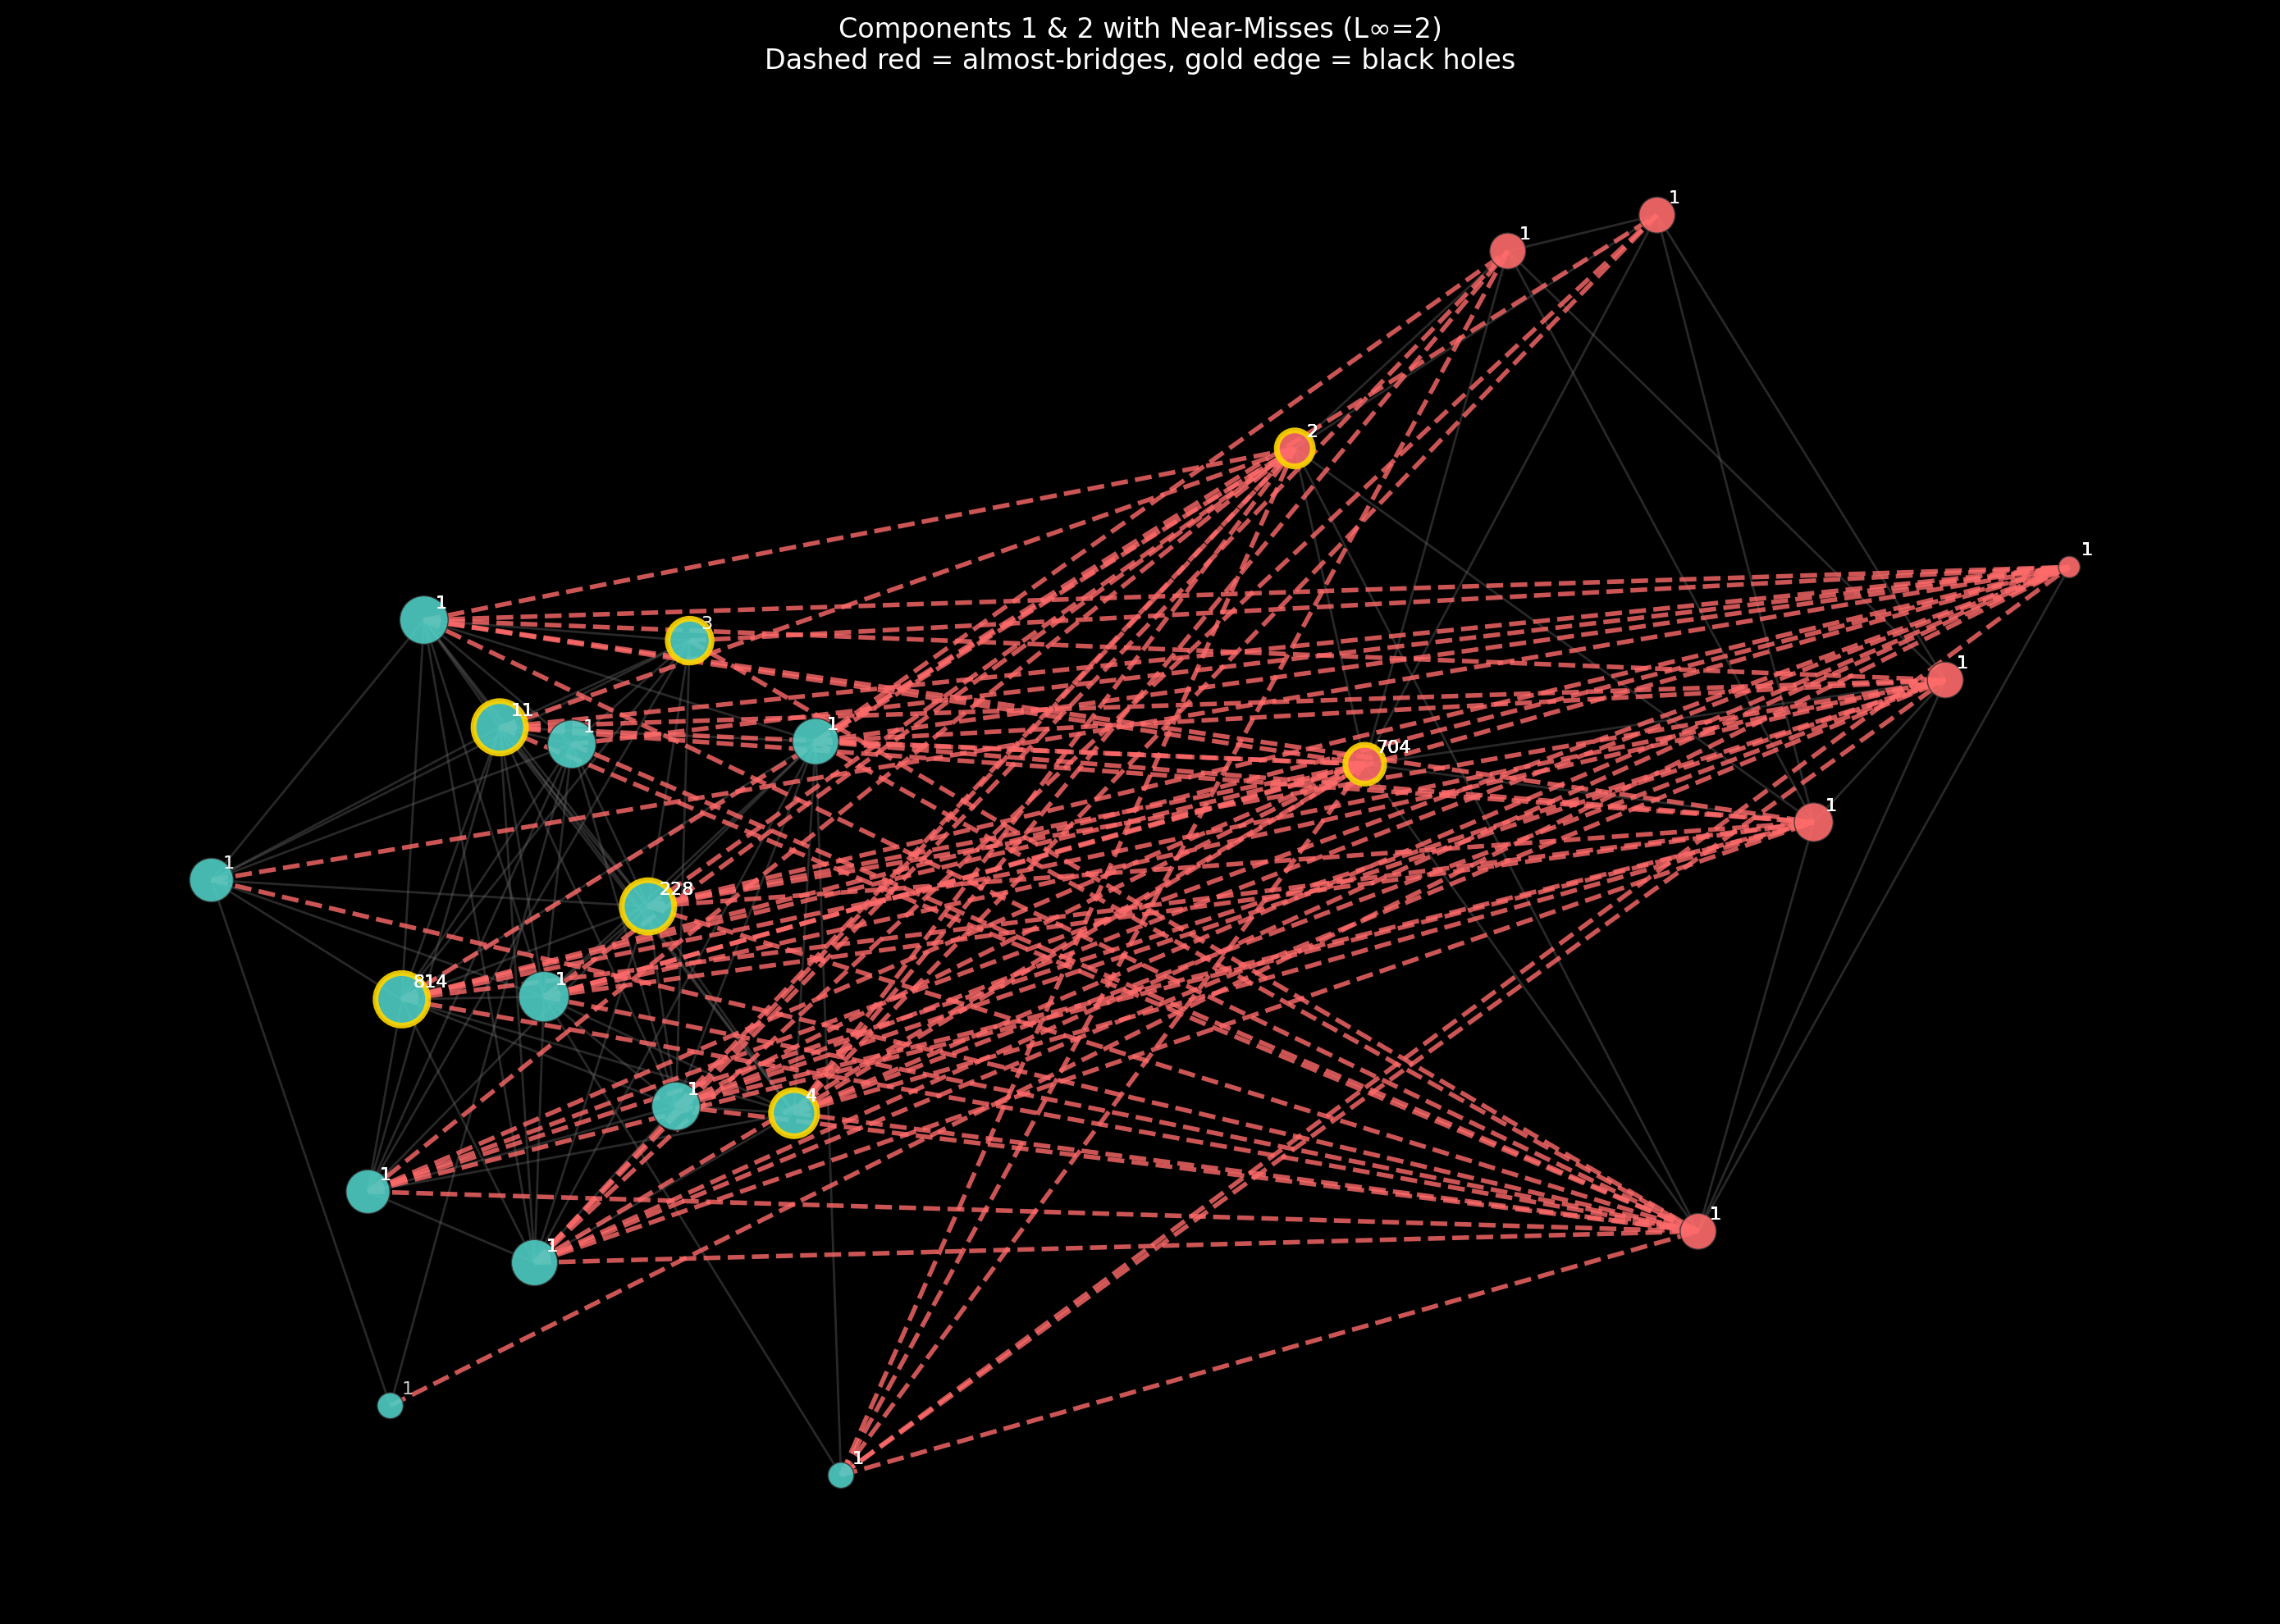

In [51]:
# Visualize the near-misses: show C1 and C2 together with the almost-bridge highlighted
fig, ax = plt.subplots(figsize=(14, 10), dpi=200)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Combine C1 and C2 into one graph for visualization
c1_c2_nodes = top3[0] + top3[1]
combined = G.subgraph(c1_c2_nodes).copy()

# Add the near-miss edges as dashed lines
near_miss_edges = [(nm['node_i'], nm['node_j']) for nm in near_misses 
                   if nm['comp_i'] == 1 and nm['comp_j'] == 2]

# Layout - use spring but with component separation
pos = nx.spring_layout(combined, seed=42, k=3, iterations=100)

# Shift components apart slightly for visibility
for n in top3[1]:
    pos[n] = (pos[n][0] + 2, pos[n][1])

# Draw real edges
nx.draw_networkx_edges(combined, pos, ax=ax, alpha=0.4, edge_color='#666666', width=1)

# Draw near-miss edges
nx.draw_networkx_edges(combined, pos, edgelist=near_miss_edges, ax=ax,
                       style='dashed', alpha=0.8, edge_color='#ff6b6b', width=2)

# Draw nodes
for comp_idx, comp in enumerate([top3[0], top3[1]]):
    color = '#4ECDC4' if comp_idx == 0 else '#FF6B6B'
    
    degrees = [combined.degree(n) for n in comp]
    sizes = [50 + d * 40 for d in degrees]
    
    is_bh = [G.nodes[n]['is_black_hole'] for n in comp]
    
    nx.draw_networkx_nodes(combined, pos, nodelist=comp, ax=ax,
                           node_size=sizes, node_color=color, alpha=0.9,
                           edgecolors=['gold' if bh else '#333333' for bh in is_bh],
                           linewidths=[2.5 if bh else 0.5 for bh in is_bh])

# Label near-miss nodes
for nm in near_misses:
    if nm['comp_i'] == 1 and nm['comp_j'] == 2:
        for node_key in ['node_i', 'node_j']:
            n = nm[node_key]
            x, y = pos[n]
            ax.annotate(f"{G.nodes[n]['token_count']}", (x, y),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, color='white', alpha=0.8)

ax.set_title(f'Components 1 & 2 with Near-Misses (L∞=2)\n'
             f'Dashed red = almost-bridges, gold edge = black holes',
             fontsize=12, color='white')
ax.axis('off')

plt.tight_layout()
plt.savefig('../../notebooks/analysis/frozen_smoke_nearmiss.png',
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## 5. Black Hole Geography

Are black holes central (hubs) or peripheral (leaves)? 
Show betweenness centrality vs token count.

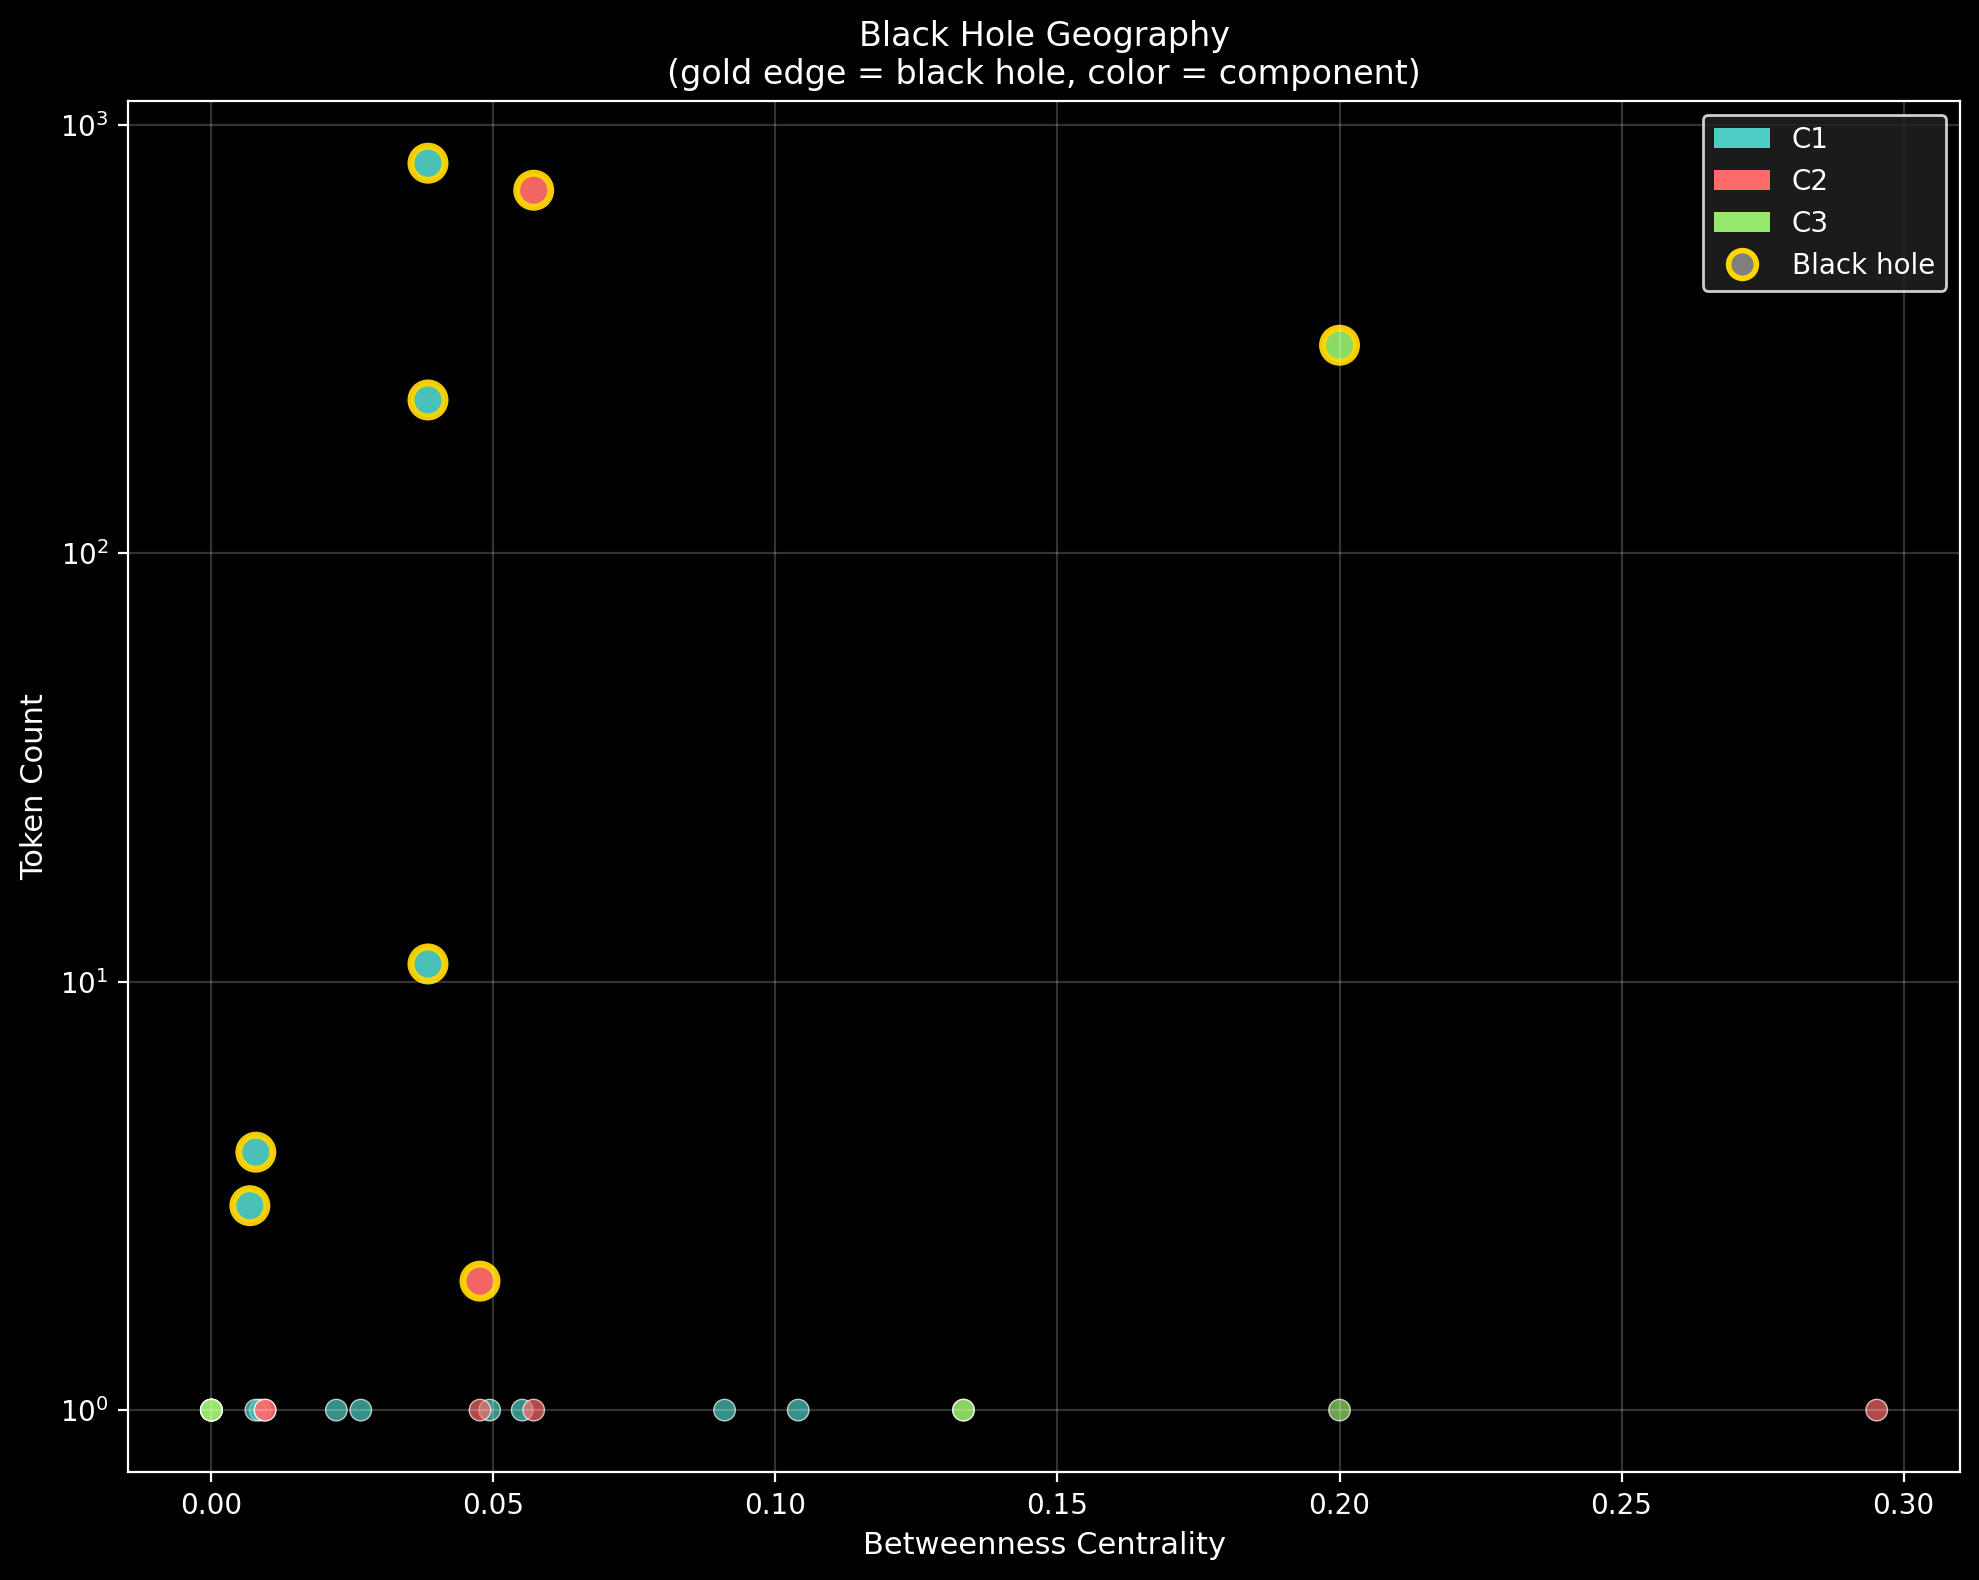

In [52]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Compute betweenness centrality for each component
all_nodes = top3[0] + top3[1] + top3[2]
betweenness = {}

for comp in top3:
    subgraph = G.subgraph(comp)
    bc = nx.betweenness_centrality(subgraph)
    betweenness.update(bc)

# Extract data
centrality = [betweenness[n] for n in all_nodes]
token_cts = [G.nodes[n]['token_count'] for n in all_nodes]
is_bh = [G.nodes[n]['is_black_hole'] for n in all_nodes]
comp_id = [1 if n in top3[0] else 2 if n in top3[1] else 3 for n in all_nodes]

# Plot singletons
c_s = [c for c, bh in zip(centrality, is_bh) if not bh]
t_s = [t for t, bh in zip(token_cts, is_bh) if not bh]
comp_s = [comp for comp, bh in zip(comp_id, is_bh) if not bh]
colors_s = ['#4ECDC4' if c==1 else '#FF6B6B' if c==2 else '#95E86B' for c in comp_s]

ax.scatter(c_s, t_s, c=colors_s, s=60, alpha=0.7, edgecolors='white', linewidths=0.5)

# Plot black holes
c_bh = [c for c, bh in zip(centrality, is_bh) if bh]
t_bh = [t for t, bh in zip(token_cts, is_bh) if bh]
comp_bh = [comp for comp, bh in zip(comp_id, is_bh) if bh]
colors_bh = ['#4ECDC4' if c==1 else '#FF6B6B' if c==2 else '#95E86B' for c in comp_bh]

ax.scatter(c_bh, t_bh, c=colors_bh, s=150, alpha=0.95, 
           edgecolors='gold', linewidths=2.5, marker='o')

ax.set_xlabel('Betweenness Centrality', fontsize=11, color='white')
ax.set_ylabel('Token Count', fontsize=11, color='white')
ax.set_yscale('log')
ax.set_title('Black Hole Geography\n'
             '(gold edge = black hole, color = component)',
             fontsize=12, color='white')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_color('white')
ax.grid(True, alpha=0.2, color='white')

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#4ECDC4', label='C1'),
    Patch(facecolor='#FF6B6B', label='C2'),
    Patch(facecolor='#95E86B', label='C3'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=10, markeredgecolor='gold', markeredgewidth=2, 
           linestyle='None', label='Black hole')
]
ax.legend(handles=legend_elements, facecolor='#222222', 
          edgecolor='white', labelcolor='white', loc='upper right')

plt.tight_layout()
plt.savefig('../../notebooks/analysis/frozen_smoke_blackholes.png',
            dpi=200, bbox_inches='tight', facecolor='black')
plt.show()

## Summary

What did we learn about the frozen smoke?

In [53]:
print("FROZEN SMOKE SUMMARY")
print("=" * 60)
print()

for idx, comp in enumerate(top3):
    subgraph = G.subgraph(comp)
    
    tokens = sum(G.nodes[n]['token_count'] for n in comp)
    n_bh = sum(1 for n in comp if G.nodes[n]['is_black_hole'])
    density = nx.density(subgraph)
    clustering = nx.average_clustering(subgraph)
    degrees = [subgraph.degree(n) for n in comp]
    
    # Hub identification
    bc = nx.betweenness_centrality(subgraph)
    hub = max(bc, key=bc.get)
    hub_is_bh = G.nodes[hub]['is_black_hole']
    hub_tokens = G.nodes[hub]['token_count']
    
    print(f"Component {idx+1}:")
    print(f"  Vectors: {len(comp)}, Tokens: {tokens:,}")
    print(f"  Black holes: {n_bh}")
    print(f"  Density: {density:.3f}, Clustering: {clustering:.3f}")
    print(f"  Degree range: {min(degrees)}-{max(degrees)}, mean: {np.mean(degrees):.1f}")
    print(f"  Central hub: node {hub} ({'BLACK HOLE' if hub_is_bh else 'singleton'}, {hub_tokens} tokens)")
    print()

FROZEN SMOKE SUMMARY

Component 1:
  Vectors: 15, Tokens: 1,070
  Black holes: 5
  Density: 0.629, Clustering: 0.817
  Degree range: 2-12, mean: 8.8
  Central hub: node 46 (singleton, 1 tokens)

Component 2:
  Vectors: 8, Tokens: 712
  Black holes: 2
  Density: 0.679, Clustering: 0.688
  Degree range: 1-6, mean: 4.8
  Central hub: node 59 (singleton, 1 tokens)

Component 3:
  Vectors: 7, Tokens: 312
  Black holes: 1
  Density: 0.619, Clustering: 0.790
  Degree range: 2-5, mean: 3.7
  Central hub: node 75 (BLACK HOLE, 306 tokens)

